# Programming Assigment 2

Egor Fadeev, 12313685 - Thomas Geier, 12026958

Implement a SVM (in the primal; hinge-loss + regularizer) and use SGD/Adagrad for optimization. You will consider the following two models/features:

A linear SVM using the original features of the data; and
a SVM using RFFs for approximating a Gaussian kernel.
Both models will be trained using a standard variant of SGD or Adagrad.

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score as cross_val_sk
from sklearn.svm import SVC
import time
from utils import *
from model import *
from optimizers import *
from RFF import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load and preprocess data
X_tiny, y_tiny = get_data('tiny')
X_large, y_large = get_data('large')
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = get_data('imdb')

scaler = StandardScaler()
X_tiny_scaled = scaler.fit_transform(X_tiny)
X_large_scaled = scaler.fit_transform(X_large)
X_train_imdb_scaled = scaler.fit_transform(X_train_imdb)
X_test_imdb_scaled = scaler.transform(X_test_imdb)

# Get validation dataset for IMDB
np.random.seed(420)
val_indices = np.random.choice(X_train_imdb_scaled.shape[0], size=5000, replace=False)

X_val_imdb = X_train_imdb_scaled[val_indices]
X_train_imdb = np.delete(X_train_imdb_scaled, val_indices, axis=0)
y_val_imdb = y_train_imdb[val_indices]
y_train_imdb = np.delete(y_train_imdb, val_indices, axis=0)

X_train_val_imdb = np.vstack((X_train_imdb, X_val_imdb))
y_train_val_imdb = np.vstack((y_train_imdb, y_val_imdb))

## Linear SVM Model

As a baseline model implement a linear SVM and train it in a standard way (i.e., use standard mini-batch SGD). Train a SVM for each of the datasets, select a suitable learning rate and regularization parameter.

### Tiny dataset

First, we are going to train a SVM for the `toydata_tiny.csv` data:

In [ ]:
# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
n_epochs = 30
batch_size = 10

In [19]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_tiny_scaled, y_tiny, model=LinearSVM(), optimizer=MiniBatchSGD(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 547.06it/s, loss=0.179]

Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 0.9949999999999999


In [25]:
optimizer = MiniBatchSGD(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 618.86it/s, loss=0.0512]


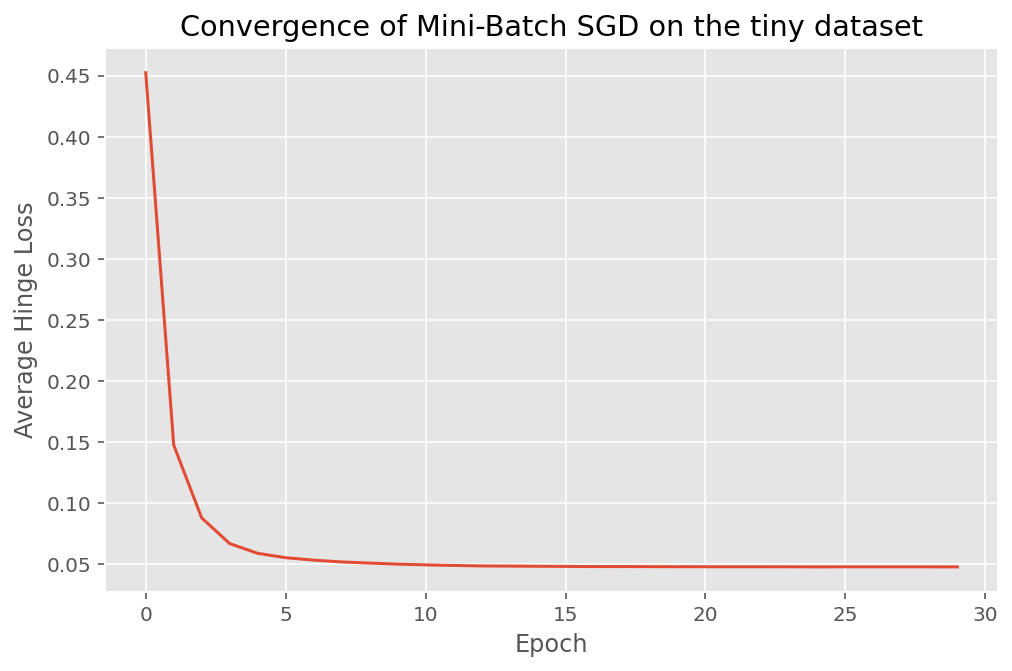

Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


In [26]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_tiny_scaled, y_tiny, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD on the tiny dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the tiny dataset: {average_accuracy:.2f}")
print(f"Average runtime on the tiny dataset: {average_runtime:.2f}")

### Large dataset

Now lets do the same for `toydata_large.csv`:

In [27]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_large_scaled, y_large, model=LinearSVM(), optimizer=MiniBatchSGD(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, loss=0.028] 

Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 1.0


In [28]:
optimizer = MiniBatchSGD(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, loss=0.00421]


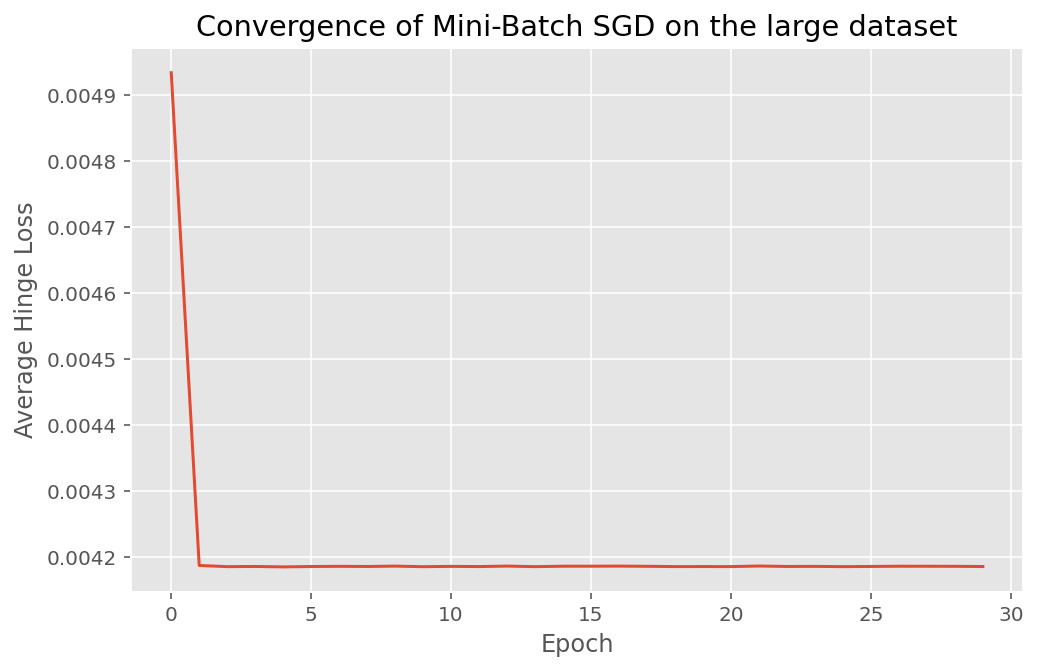

Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 24.57


In [30]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_large_scaled, y_large, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Mini-Batch SGD on the large dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the large dataset: {average_accuracy:.2f}")
print(f"Average runtime on the large dataset: {average_runtime:.2f}")

### IMDB dataset

Finally we are going to train the model for `imdb.npz`:

In [4]:
# Parameters to test
learning_rates = [0.001, 0.01]
lambdas = [0.01, 0.1]
n_epochs = 30
batch_size = 10

best_accuracy = 0
best_params = None

for lr in learning_rates:
    for lambda_ in lambdas:
        model = LinearSVM(lambda_=lambda_)
        optimizer = MiniBatchSGD(learning_rate=lr)

        model.fit(X_train_imdb, y_train_imdb, optimizer, n_epochs, batch_size)
        y_pred = model.predict(X_val_imdb)
        accuracy = accuracy_score(y_val_imdb, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (lr, lambda_)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [35:02<00:00, 70.07s/it, loss=[9.34598365]]


Best Learning Rate: 0.001, Best Lambda: 0.01
Best Accuracy: 0.8504


Training Progress: 100%|██████████| 30/30 [41:23<00:00, 82.79s/it, loss=[0.69774063]]


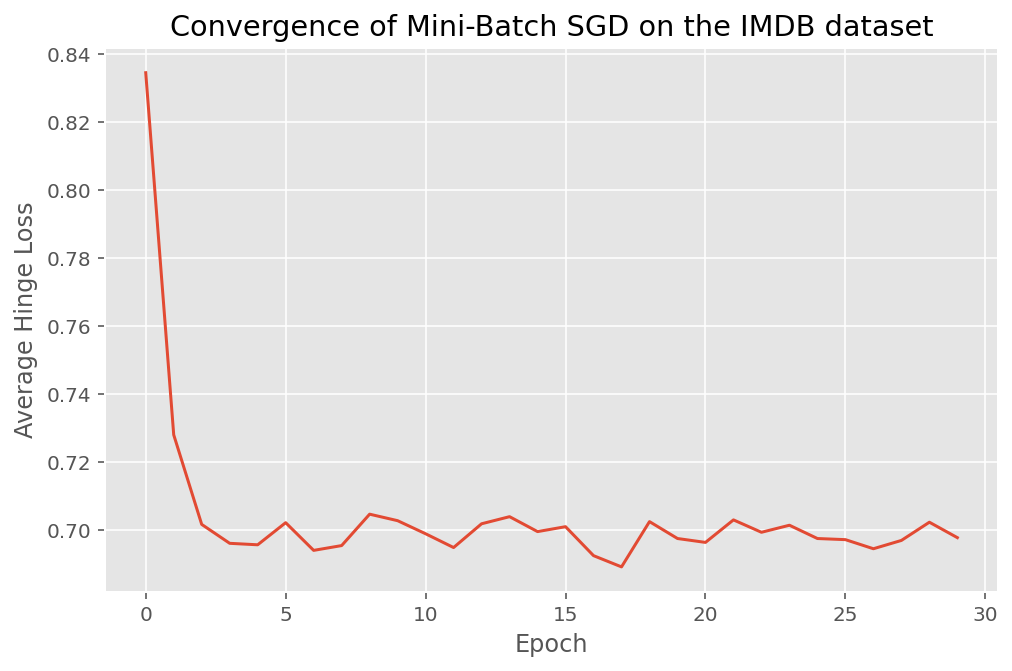

Accuracy on the IMDB dataset: 0.86
Runtime on the IMDB dataset: 2483.92


In [11]:
# Fit the model with the best hyperparameters
model = LinearSVM(lambda_=best_params[1])
optimizer = MiniBatchSGD(learning_rate=best_params[0])

start_time = time.time()
loss = model.fit(X_train_val_imdb, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)
runtime = time.time() - start_time

test_pred = model.predict(X_test_imdb_scaled)
accuracy = accuracy_score(y_test_imdb, test_pred)

# Plotting convergence
plt.plot(loss)
plt.title('Convergence of Mini-Batch SGD on the IMDB dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
print(f"Runtime on the IMDB dataset: {runtime:.2f}")

## Optimization using Adagrad

Implement Adagrad using the diagonal approximation for optimization. Train a linear SVMs using the original features (i.e., do not use the RFFs).

### Tiny dataset

Let's train SVM with Adagrad on `toydata_tiny.csv`:

In [13]:
# Parameters to test
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.05, 0.1]
n_epochs = 30
batch_size = 10

In [16]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_tiny_scaled, y_tiny, model=LinearSVM(), optimizer=Adagrad(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 438.50it/s, loss=0.633]

Best Learning Rate: 0.1, Best Lambda: 0.01
Best Accuracy: 0.8550000000000001


In [22]:
optimizer = Adagrad(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 137.79it/s, loss=0.128]


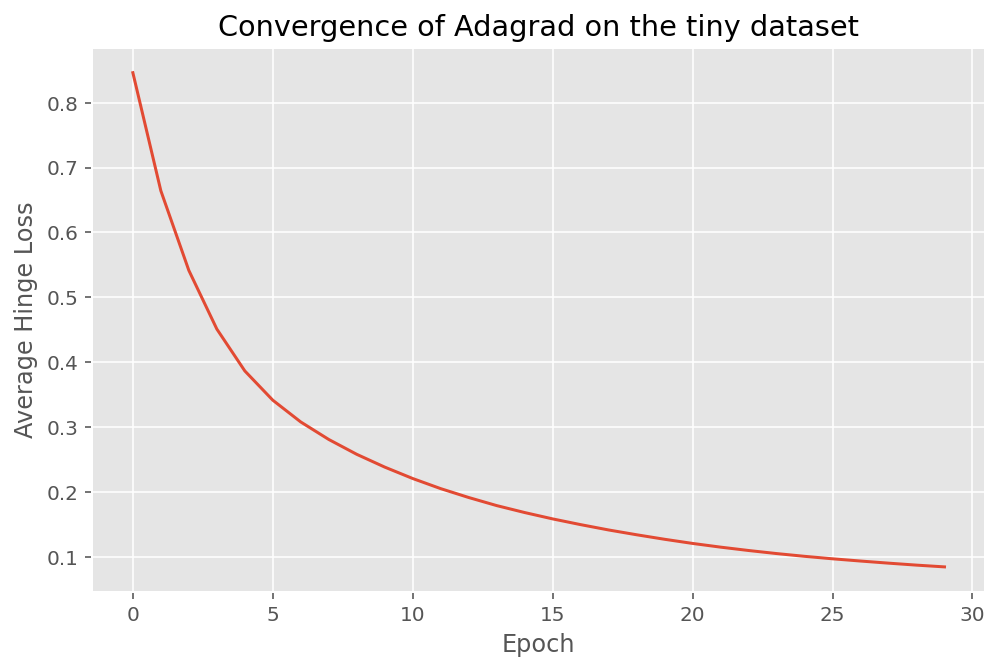

Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


In [23]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_tiny_scaled, y_tiny, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Adagrad on the tiny dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the tiny dataset: {average_accuracy:.2f}")
print(f"Average runtime on the tiny dataset: {average_runtime:.2f}")

### Large dataset

Now let's train it on `toydata_large.csv`:

In [24]:
# Perform cross-validation
best_params, best_accuracy, all_results = grid_search_svm(X_large_scaled, y_large, model=LinearSVM(), optimizer=Adagrad(), 
            lambdas=lambdas, learning_rates=learning_rates, n_epochs=n_epochs, batch_size=batch_size)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.0335]

Best Learning Rate: 0.1, Best Lambda: 0.01
Best Accuracy: 1.0


In [4]:
optimizer = Adagrad(learning_rate=best_params[0])
model = LinearSVM(lambda_=best_params[1])

Training Progress: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, loss=0.00563]


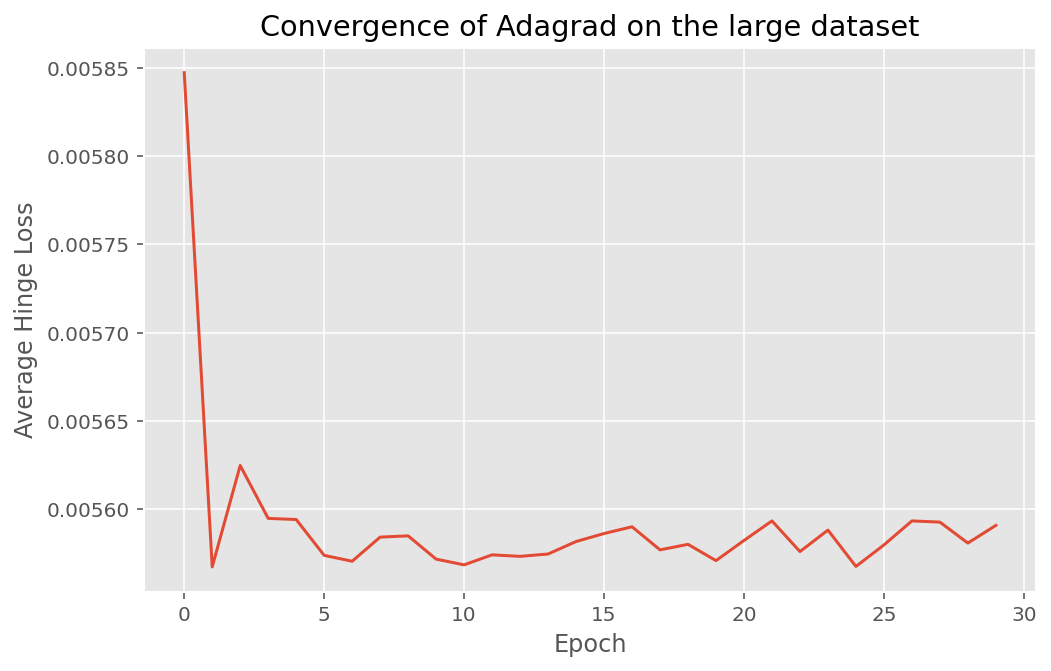

Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 24.65


In [28]:
average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_large_scaled, y_large, model, optimizer, n_epochs, batch_size)

# Plotting average convergence across folds
average_loss_history = np.mean(all_loss_histories, axis=0)
plt.plot(average_loss_history)
plt.title('Convergence of Adagrad on the large dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Average 5-fold cross-validation accuracy on the large dataset: {average_accuracy:.2f}")
print(f"Average runtime on the large dataset: {average_runtime:.2f}")

### IMDB dataset

Finally let's try the optimizer on `imdb.npz`:

In [5]:
# Parameters to test
learning_rates = [0.001, 0.01]
lambdas = [0.01, 0.1]
n_epochs = 30
batch_size = 10

best_accuracy = 0
best_params = None

for lr in learning_rates:
    for lambda_ in lambdas:
        model = LinearSVM(lambda_=lambda_)
        optimizer = Adagrad(learning_rate=lr)

        model.fit(X_train_imdb, y_train_imdb, optimizer, n_epochs, batch_size)
        y_pred = model.predict(X_val_imdb)
        accuracy = accuracy_score(y_val_imdb, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (lr, lambda_)

print(f"Best Learning Rate: {best_params[0]}, Best Lambda: {best_params[1]}")
print(f"Best Accuracy: {best_accuracy}")

Training Progress: 100%|██████████| 30/30 [32:04<00:00, 64.16s/it, loss=[0.33978444]]


Best Learning Rate: 0.001, Best Lambda: 0.1
Best Accuracy: 0.8896


Training Progress: 100%|██████████| 30/30 [39:52<00:00, 79.74s/it, loss=[0.20612791]]


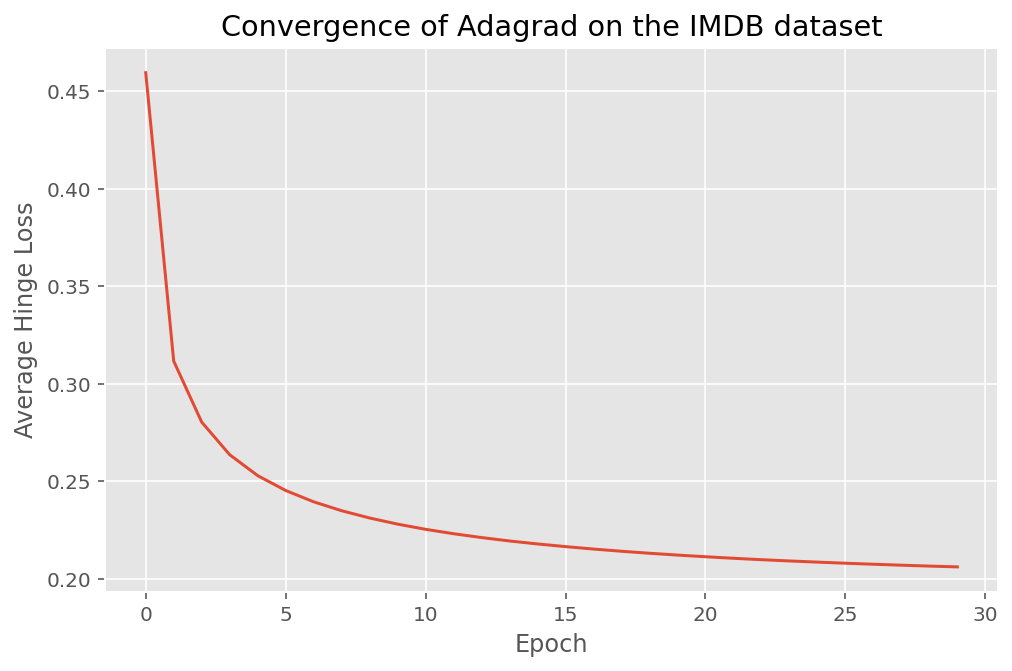

Accuracy on the IMDB dataset: 0.89
Runtime on the IMDB dataset: 2392.39


In [6]:
# Fit the model with the best hyperparameters
model = LinearSVM(lambda_=best_params[1])
optimizer = Adagrad(learning_rate=best_params[0])

start_time = time.time()
loss = model.fit(X_train_val_imdb, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)
runtime = time.time() - start_time

test_pred = model.predict(X_test_imdb_scaled)
accuracy = accuracy_score(y_test_imdb, test_pred)

# Plotting convergence
plt.plot(loss)
plt.title('Convergence of Adagrad on the IMDB dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
print(f"Runtime on the IMDB dataset: {runtime:.2f}")

Repeat your experiments using random dropout of input features with probability $p = 0.5$ for the IMDB data.

In [5]:
# Generate a boolean mask
np.random.seed(420)
mask = np.random.rand(X_train_val_imdb.shape[1]) < 0.5
# Use the mask to select columns
X_train_val_imdb_dropout = X_train_val_imdb[:, mask]

Training Progress: 100%|██████████| 30/30 [40:45<00:00, 81.52s/it, loss=[0.10831173]]


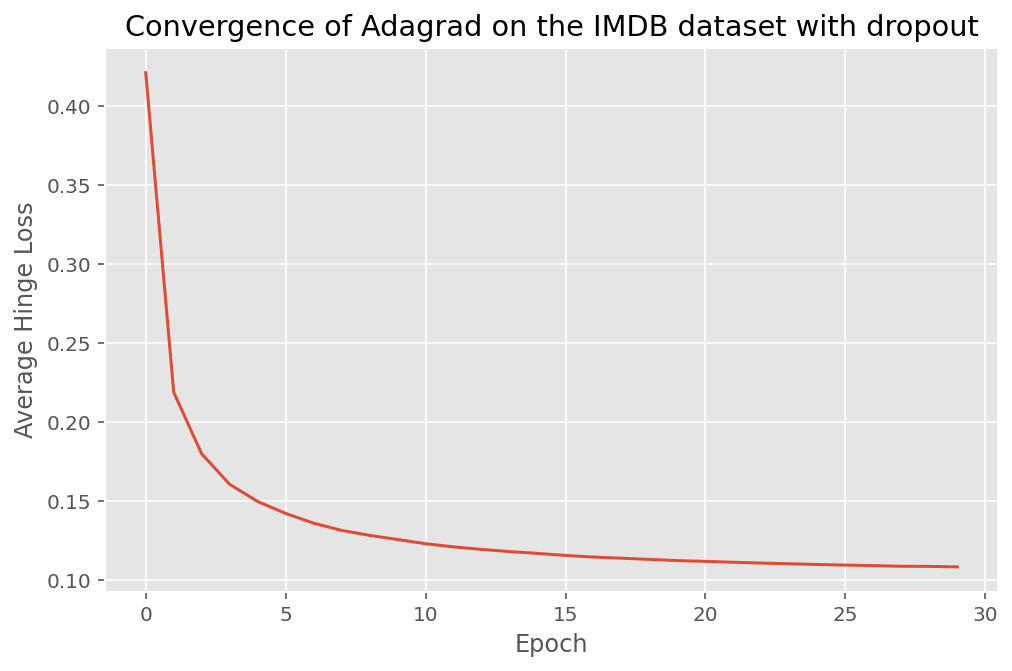

Accuracy on the IMDB dataset: 0.86


In [3]:
# Fit the model on the data with dropout
model = LinearSVM(lambda_=best_params[1])
optimizer = Adagrad(learning_rate=best_params[0])

loss = model.fit(X_train_val_imdb_dropout, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)

test_pred = model.predict(X_test_imdb_scaled)
accuracy = accuracy_score(y_test_imdb, test_pred)

# Plotting convergence
plt.plot(loss)
plt.title('Convergence of Adagrad on the IMDB dataset with dropout')
plt.xlabel('Epoch')
plt.ylabel('Average Hinge Loss')
plt.show()

print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")

## Random Fourier Features

Use RFFs to approximate a Gaussian kernel in a SVM. Train SVMs with RFFs on each of the datasets, selecting a suitable learning rate and regularization parameter. Test at least 3 different numbers of RFFs (≥ 100 features).

First, let's train the model with the SGD on the tiny dataset. In this task let's take the optimal hyperparameters for each dataset from the previous tasks.

In [60]:
model = LinearSVM(lambda_=0.01)
optimizer = MiniBatchSGD(learning_rate=0.001)

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 404.15it/s, loss=0.19]



Number of RFF = 100
Average 5-fold cross-validation accuracy on the tiny dataset: 0.98
Average runtime on the tiny dataset: 0.39


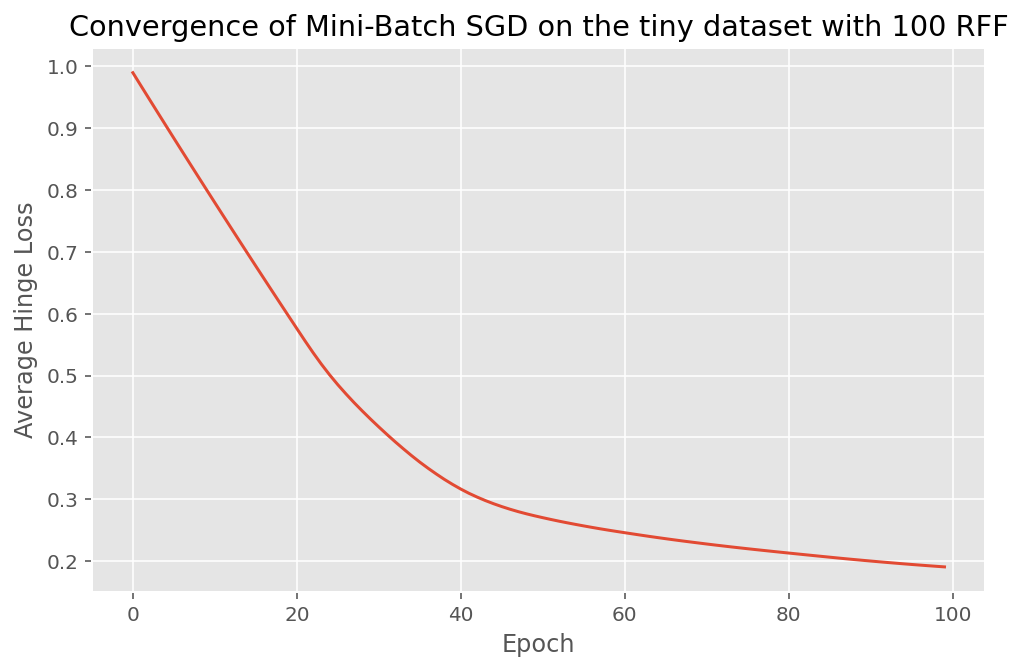

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 238.47it/s, loss=0.176]



Number of RFF = 200
Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.36


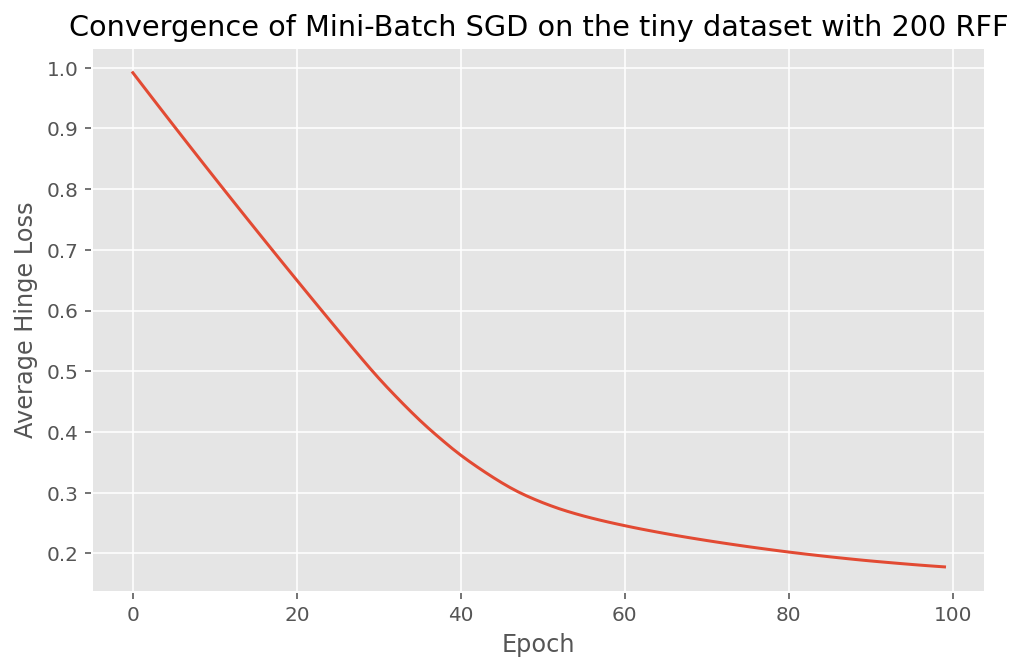

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 359.35it/s, loss=0.152]



Number of RFF = 300
Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.32


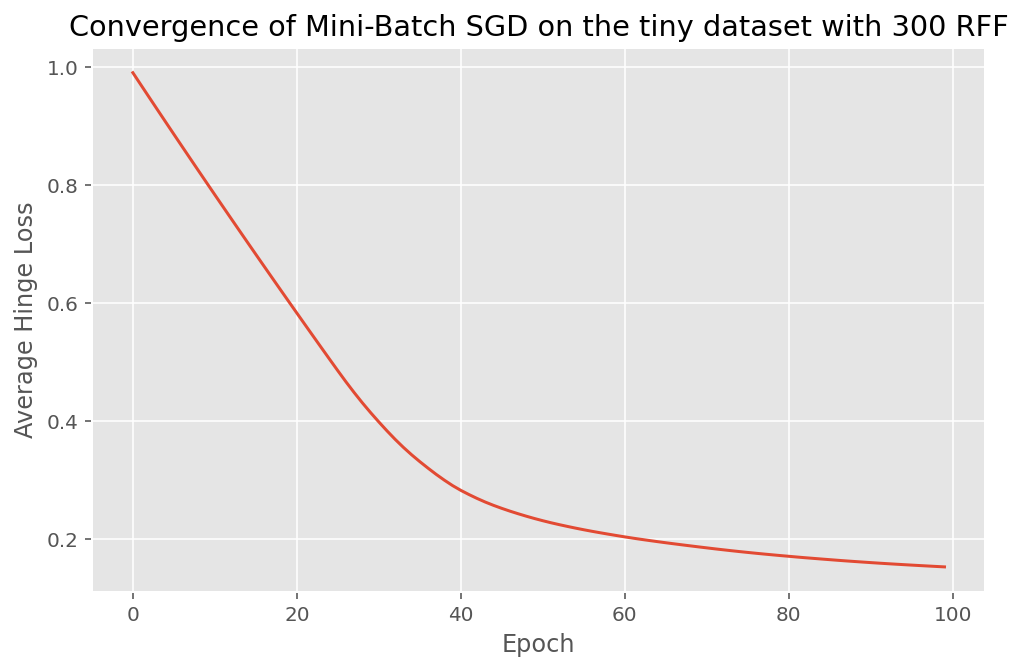

In [64]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_tiny_scaled_rff = rff.fit_transform(X_tiny_scaled)
    average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_tiny_scaled_rff, y_tiny, model, optimizer, n_epochs=100, batch_size=10)

    # Plotting average convergence across folds
    average_loss_history = np.mean(all_loss_histories, axis=0)

    print('')
    print(f"Number of RFF = {num}")
    print(f"Average 5-fold cross-validation accuracy on the tiny dataset: {average_accuracy:.2f}")
    print(f"Average runtime on the tiny dataset: {average_runtime:.2f}")

    plt.plot(average_loss_history)
    plt.title(f"Convergence of Mini-Batch SGD on the tiny dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

Now let's try SGD with RFF on the large dataset:

In [11]:
model = LinearSVM(lambda_=0.01)
optimizer = MiniBatchSGD(learning_rate=0.001)

Training Progress: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, loss=0.0191]


Number of RFF = 100
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 26.09


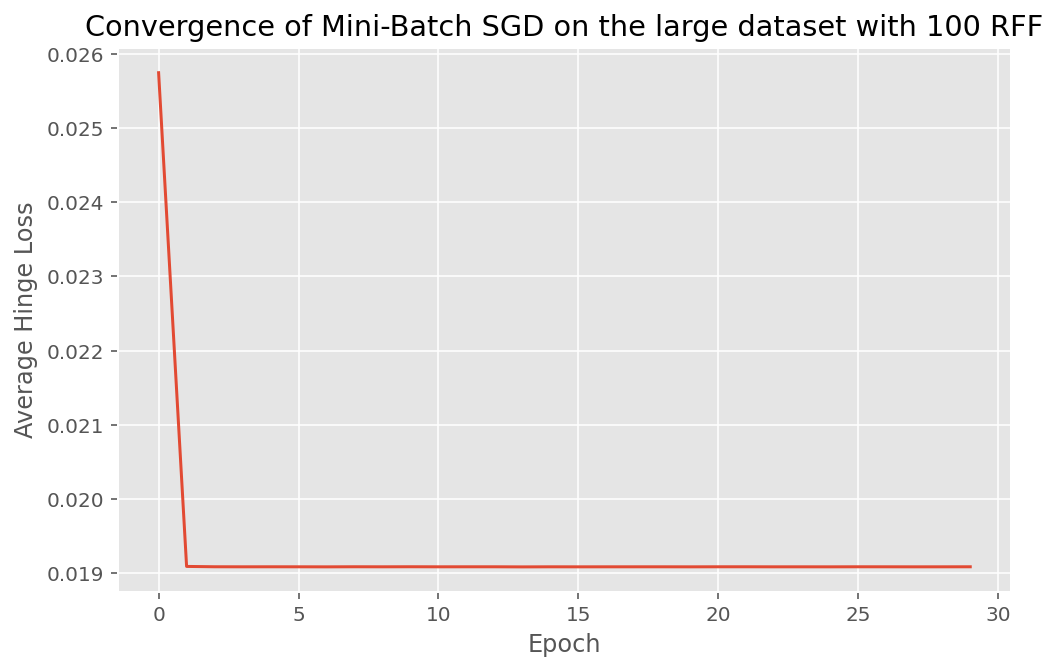

Training Progress: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it, loss=0.0254]


Number of RFF = 200
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 33.26


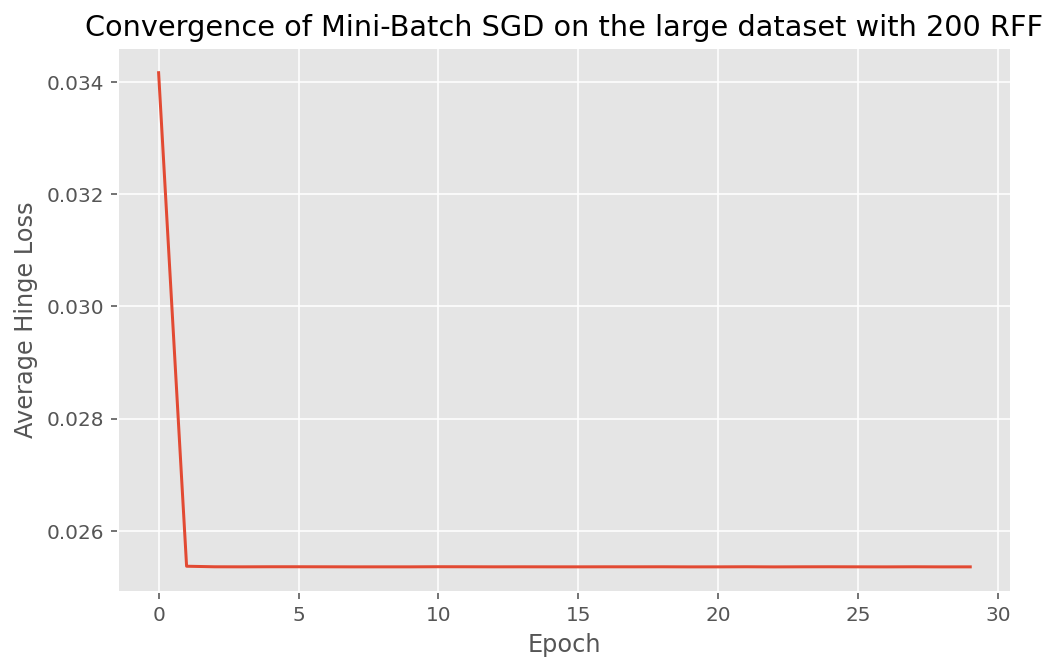

Training Progress: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it, loss=0.0237]



Number of RFF = 300
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 39.38


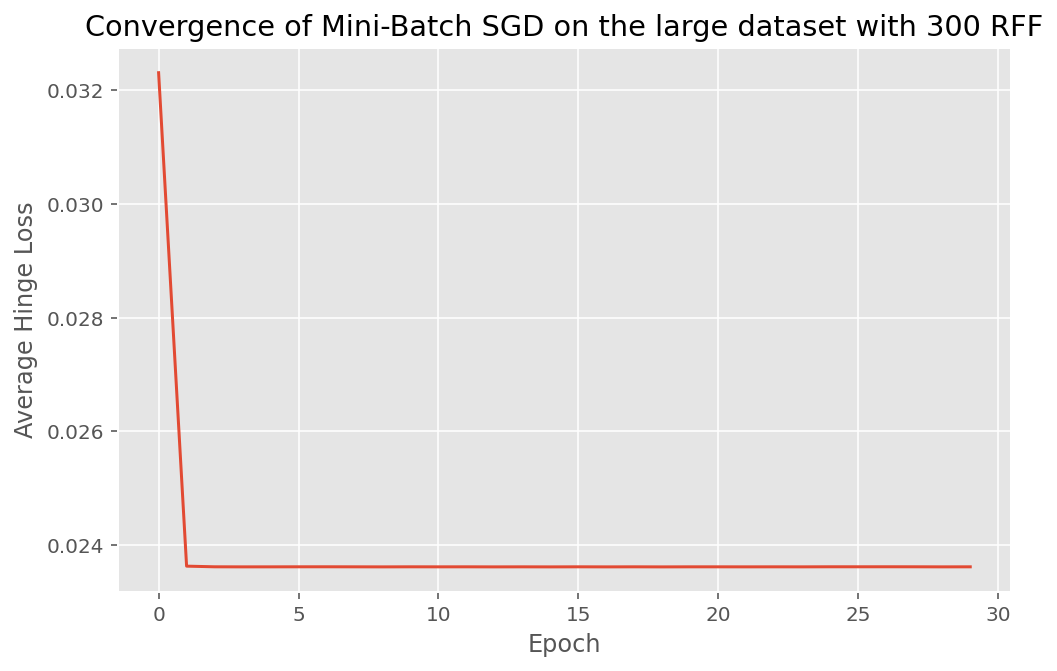

In [13]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_large_scaled_rff = rff.fit_transform(X_large_scaled)
    
    average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_large_scaled_rff, y_large, model, optimizer, n_epochs=30, batch_size=10)

    # Plotting average convergence across folds
    average_loss_history = np.mean(all_loss_histories, axis=0)

    print('')
    print(f"Number of RFF = {num}")
    print(f"Average 5-fold cross-validation accuracy on the large dataset: {average_accuracy:.2f}")
    print(f"Average runtime on the large dataset: {average_runtime:.2f}")

    plt.plot(average_loss_history)
    plt.title(f"Convergence of Mini-Batch SGD on the large dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

Finally let's try SGD with RFF on the IMDB dataset:

In [14]:
model = LinearSVM(lambda_=0.01)
optimizer = MiniBatchSGD(learning_rate=0.001)

Training Progress: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s, loss=1]



Number of RFF = 100


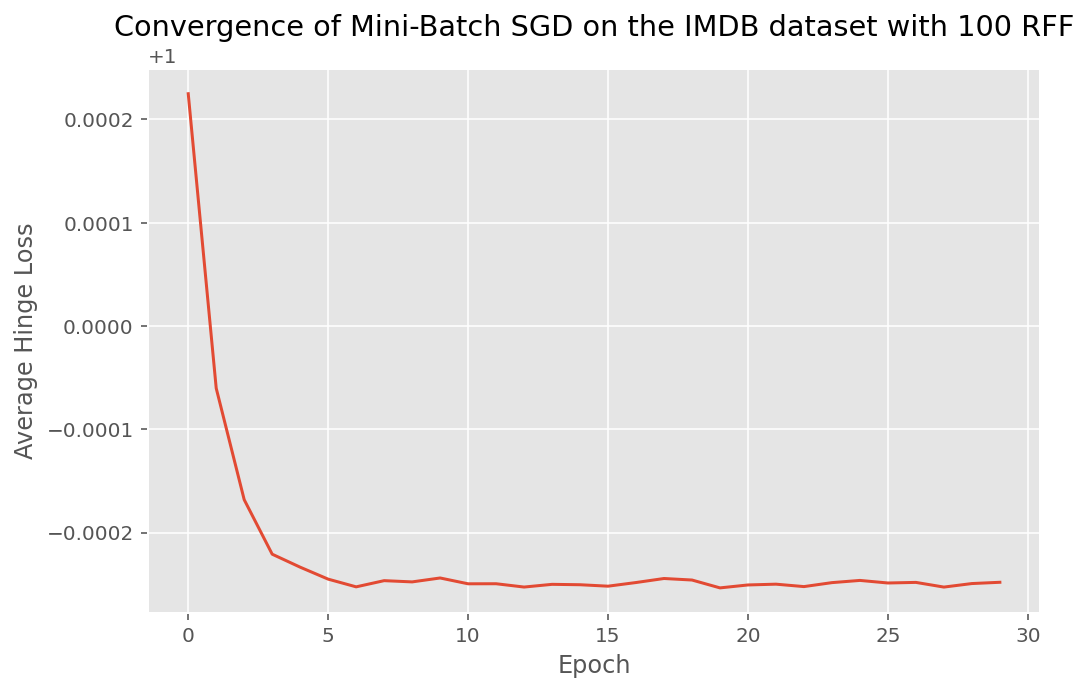

Accuracy on the IMDB dataset: 0.51
Runtime on the IMDB dataset: 17.29


Training Progress: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s, loss=0.999]


Number of RFF = 200


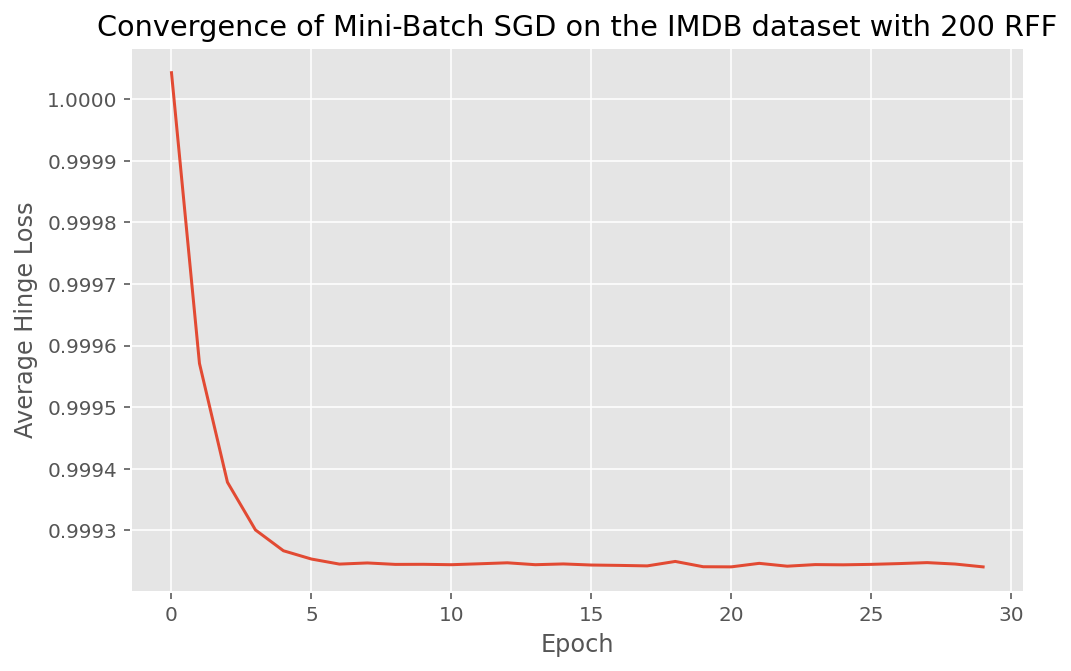

Accuracy on the IMDB dataset: 0.50
Runtime on the IMDB dataset: 17.30


Training Progress: 100%|██████████| 30/30 [00:18<00:00,  1.65it/s, loss=0.999]


Number of RFF = 300


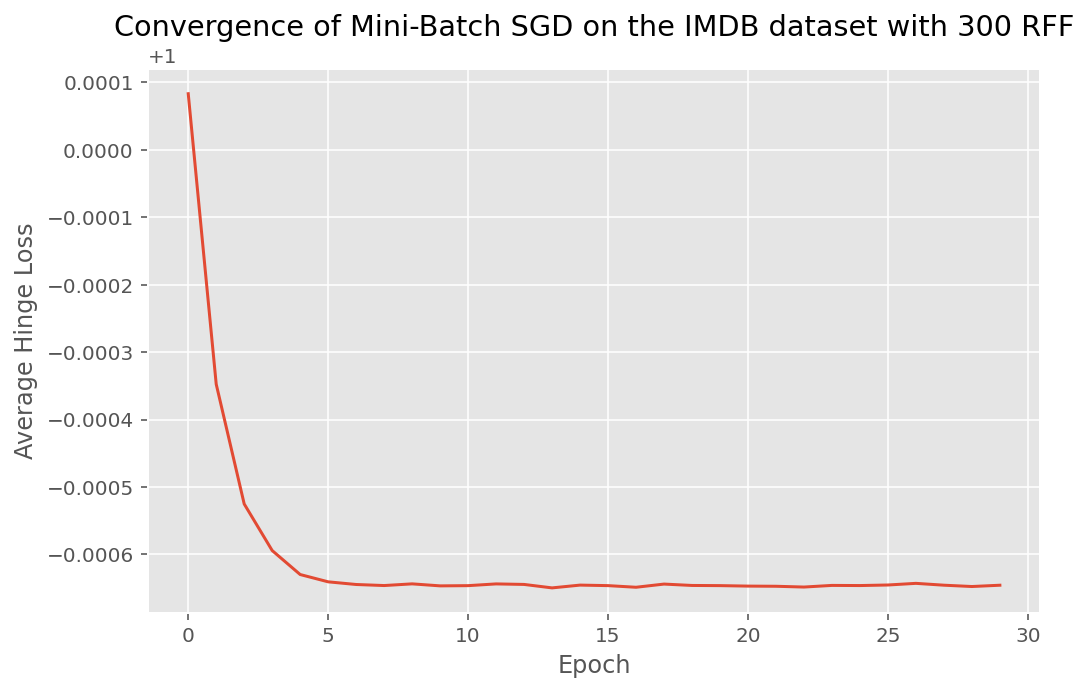

Accuracy on the IMDB dataset: 0.49
Runtime on the IMDB dataset: 18.29


In [15]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_train_val_imdb_rff = rff.fit_transform(X_train_val_imdb)
    X_test_imdb_scaled_rff = rff.transform(X_test_imdb_scaled)
    
    start_time = time.time()
    loss = model.fit(X_train_val_imdb_rff, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)
    runtime = time.time() - start_time

    test_pred = model.predict(X_test_imdb_scaled_rff)
    accuracy = accuracy_score(y_test_imdb, test_pred)

    # Plotting convergence
    print('')
    print(f"Number of RFF = {num}")

    plt.plot(loss)
    plt.title(f"Convergence of Mini-Batch SGD on the IMDB dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

    print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
    print(f"Runtime on the IMDB dataset: {runtime:.2f}")

Now let's do the same with Adagrad optimizer. Let's start with the tiny dataset:

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 132.69it/s, loss=0.148]



Number of RFF = 100
Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


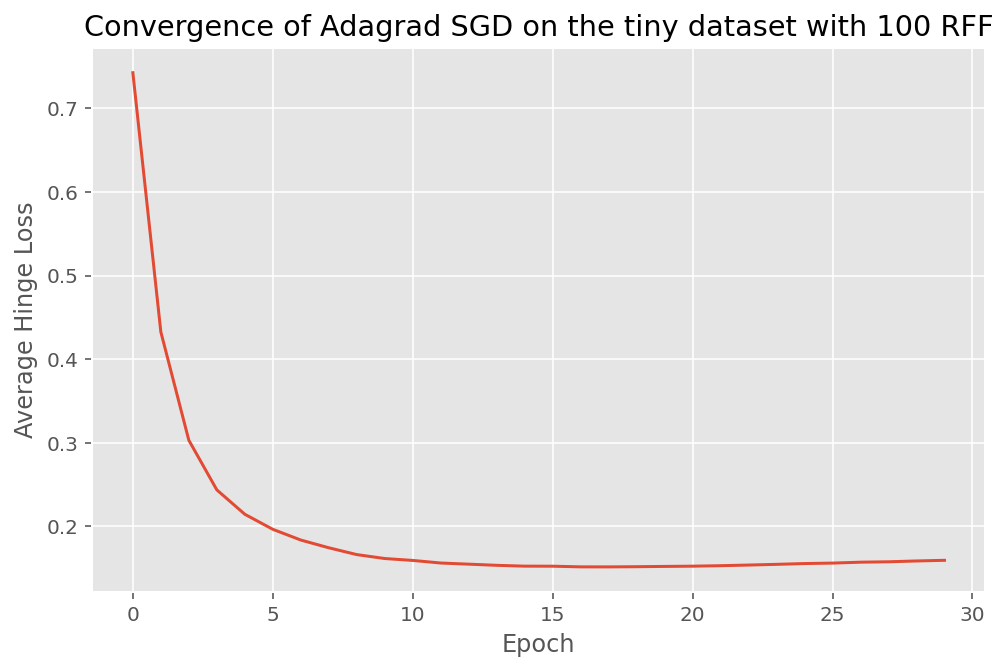

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 157.09it/s, loss=0.172]



Number of RFF = 200
Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


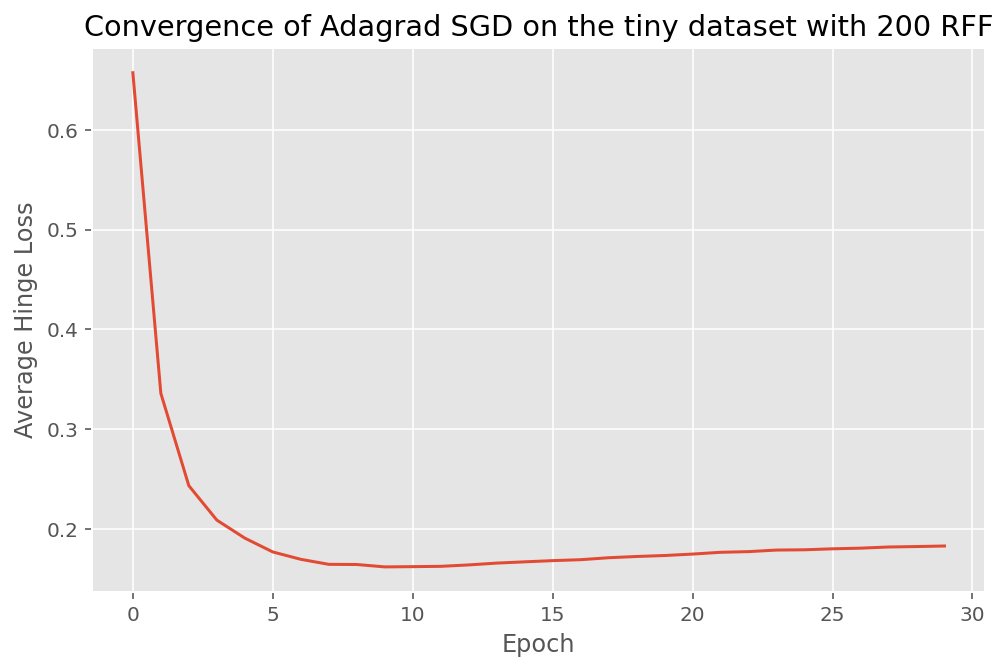

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 189.44it/s, loss=0.164]



Number of RFF = 300
Average 5-fold cross-validation accuracy on the tiny dataset: 0.99
Average runtime on the tiny dataset: 0.09


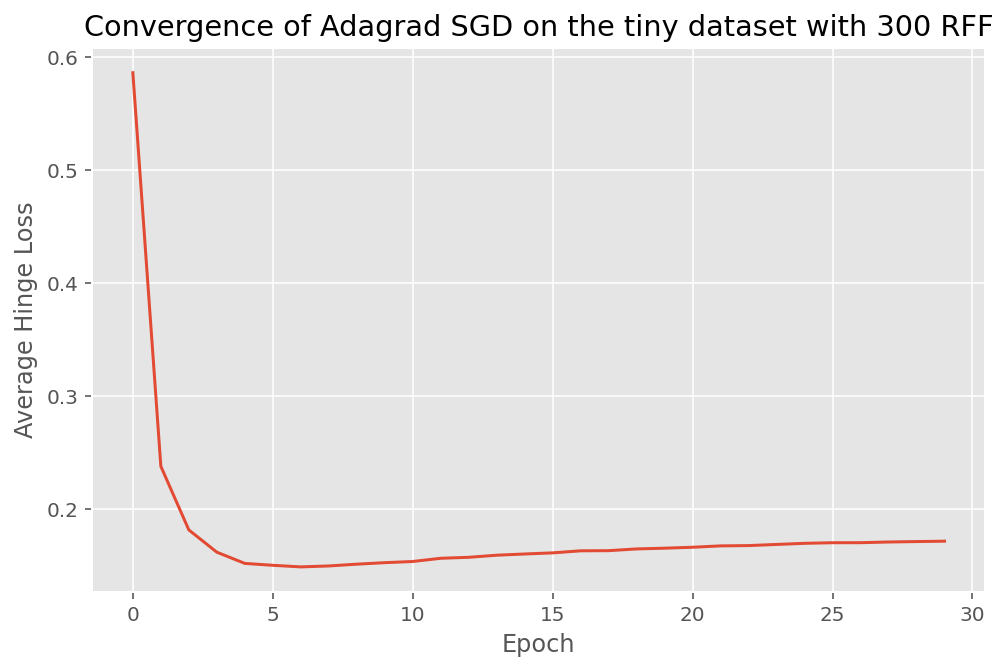

In [50]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:

    model = LinearSVM(lambda_=0.01)
    optimizer = Adagrad(learning_rate=0.1)
    
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_tiny_scaled_rff = rff.fit_transform(X_tiny_scaled)

    average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_tiny_scaled_rff, y_tiny, model, optimizer, n_epochs=30, batch_size=10)

    # Plotting average convergence across folds
    average_loss_history = np.mean(all_loss_histories, axis=0)

    print('')
    print(f"Number of RFF = {num}")
    print(f"Average 5-fold cross-validation accuracy on the tiny dataset: {average_accuracy:.2f}")
    print(f"Average runtime on the tiny dataset: {average_runtime:.2f}")

    plt.plot(average_loss_history)
    plt.title(f"Convergence of Adagrad SGD on the tiny dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

Now let's proceed with the large dataset now:

Training Progress: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s, loss=0.0237]


Number of RFF = 100
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 26.17


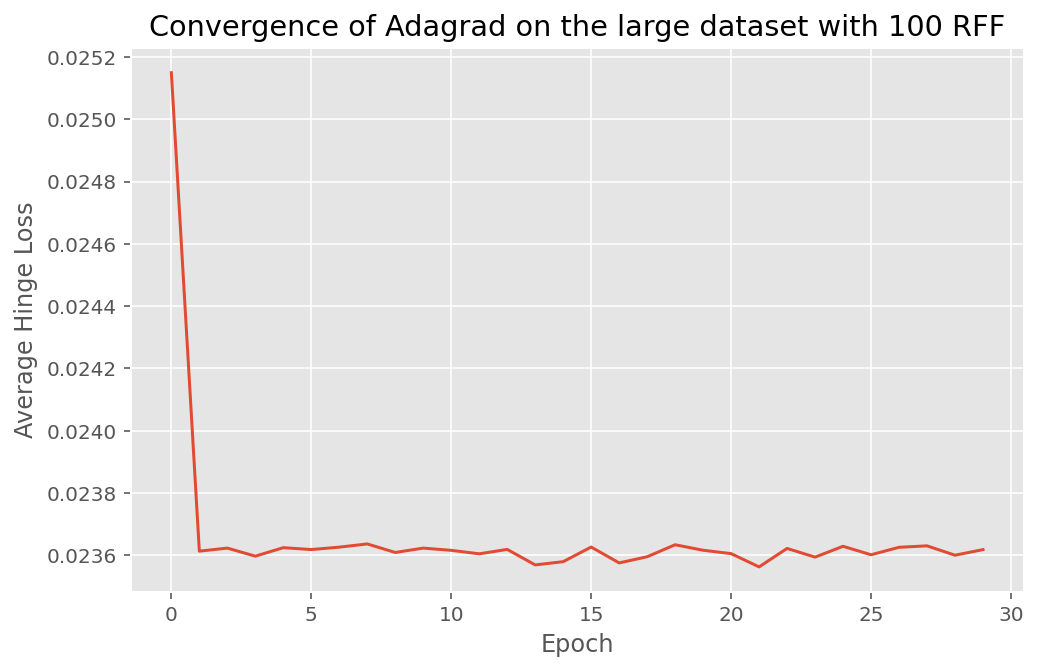

Training Progress: 100%|██████████| 30/30 [00:36<00:00,  1.22s/it, loss=0.0322]



Number of RFF = 200
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 37.71


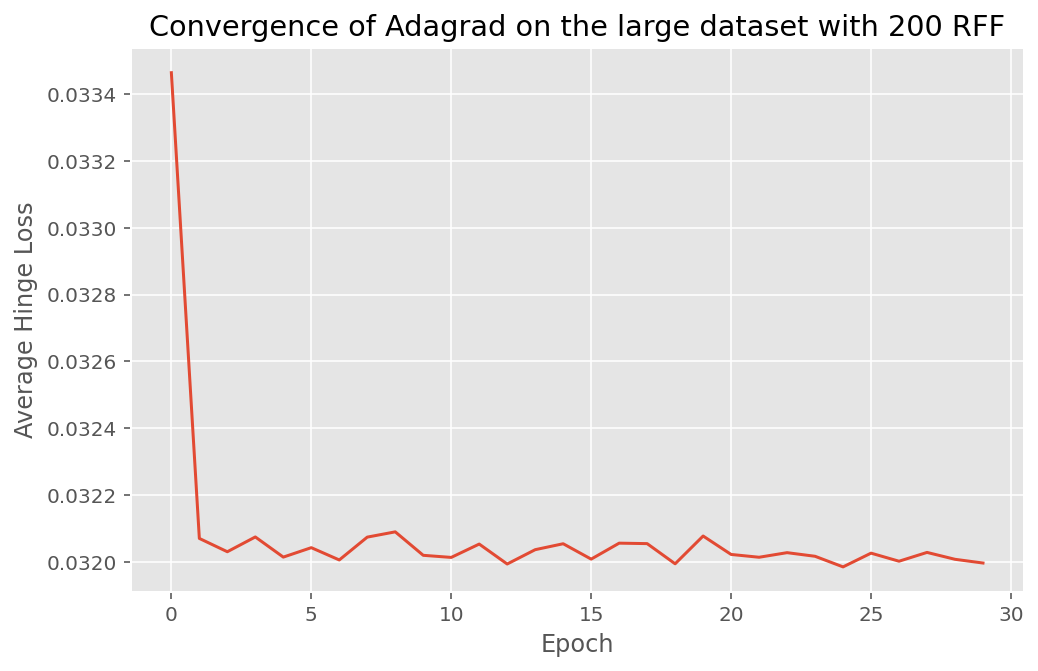

Training Progress: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it, loss=0.0297]



Number of RFF = 300
Average 5-fold cross-validation accuracy on the large dataset: 1.00
Average runtime on the large dataset: 42.18


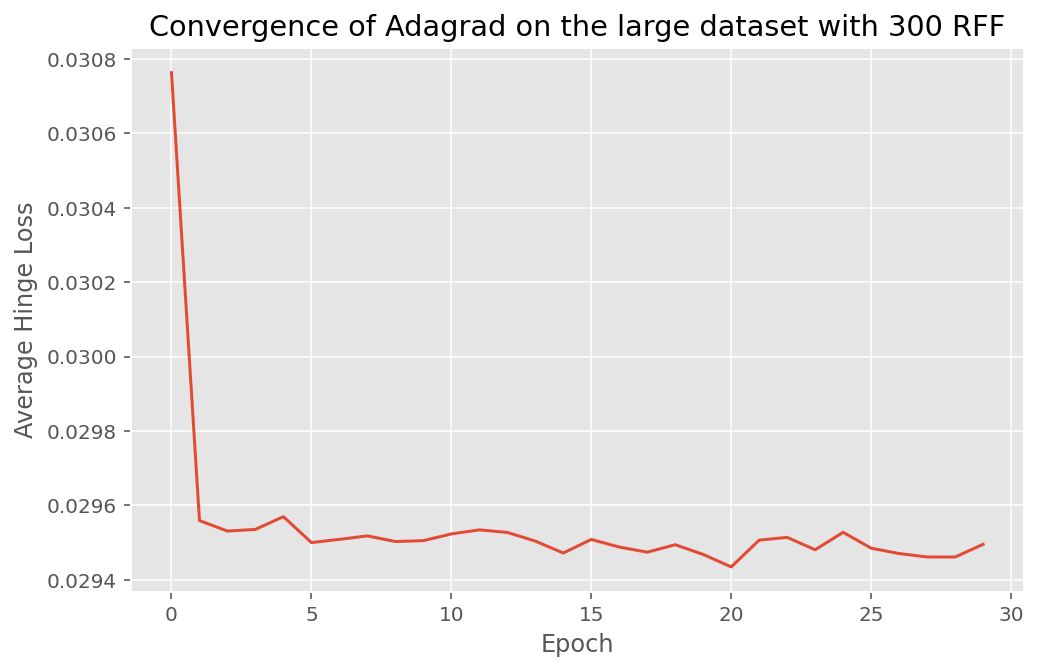

In [51]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:

    model = LinearSVM(lambda_=0.01)
    optimizer = Adagrad(learning_rate=0.1)
    
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_large_scaled_rff = rff.fit_transform(X_large_scaled)

    average_accuracy, average_runtime, all_loss_histories = cross_val_score(X_large_scaled_rff, y_large, model, optimizer, n_epochs=30, batch_size=10)

    # Plotting average convergence across folds
    average_loss_history = np.mean(all_loss_histories, axis=0)

    print('')
    print(f"Number of RFF = {num}")
    print(f"Average 5-fold cross-validation accuracy on the large dataset: {average_accuracy:.2f}")
    print(f"Average runtime on the large dataset: {average_runtime:.2f}")

    plt.plot(average_loss_history)
    plt.title(f"Convergence of Adagrad on the large dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

Finally, let's do it with the IMDB dataset

Training Progress: 100%|██████████| 30/30 [00:16<00:00,  1.79it/s, loss=1]



Number of RFF = 100


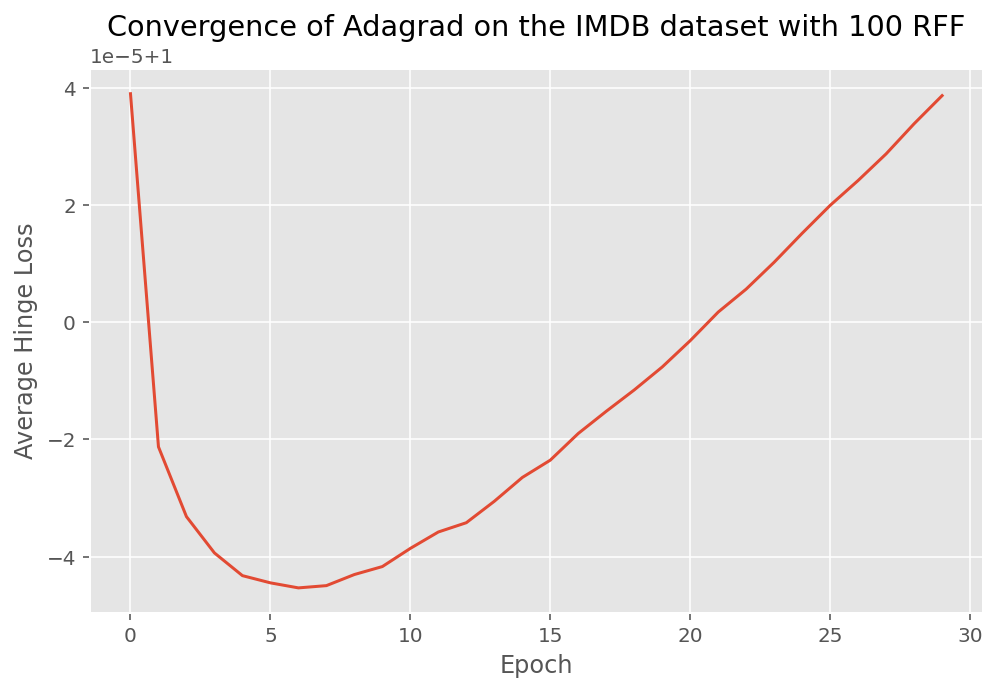

Accuracy on the IMDB dataset: 0.51
Runtime on the IMDB dataset: 16.85


Training Progress: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s, loss=1]



Number of RFF = 200


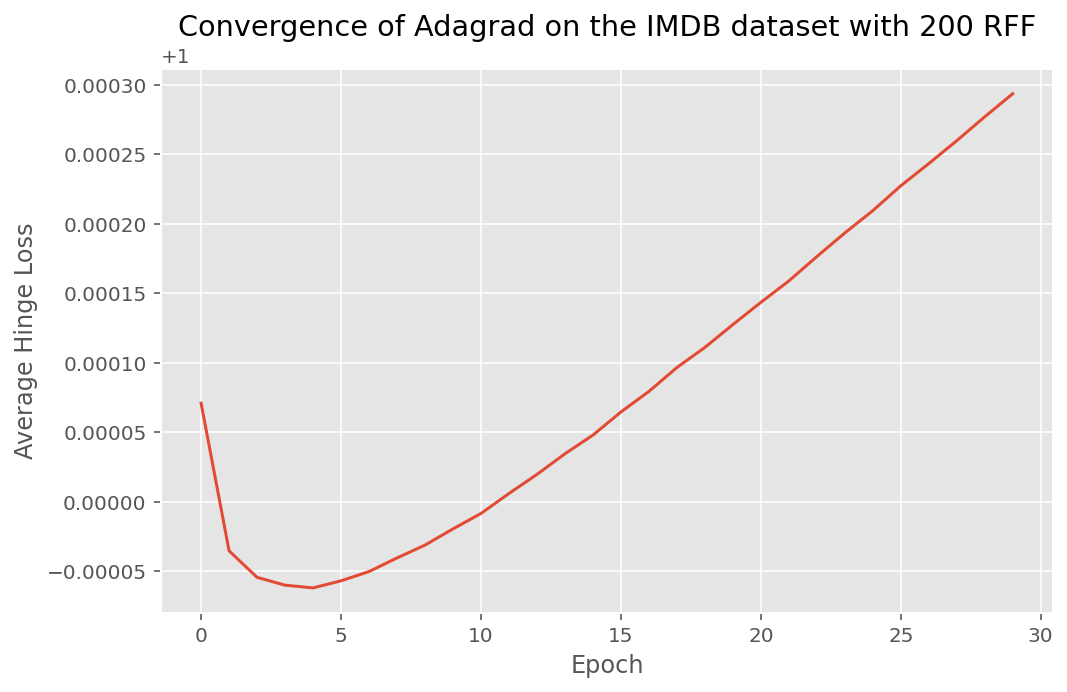

Accuracy on the IMDB dataset: 0.50
Runtime on the IMDB dataset: 18.37


Training Progress: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s, loss=1]



Number of RFF = 300


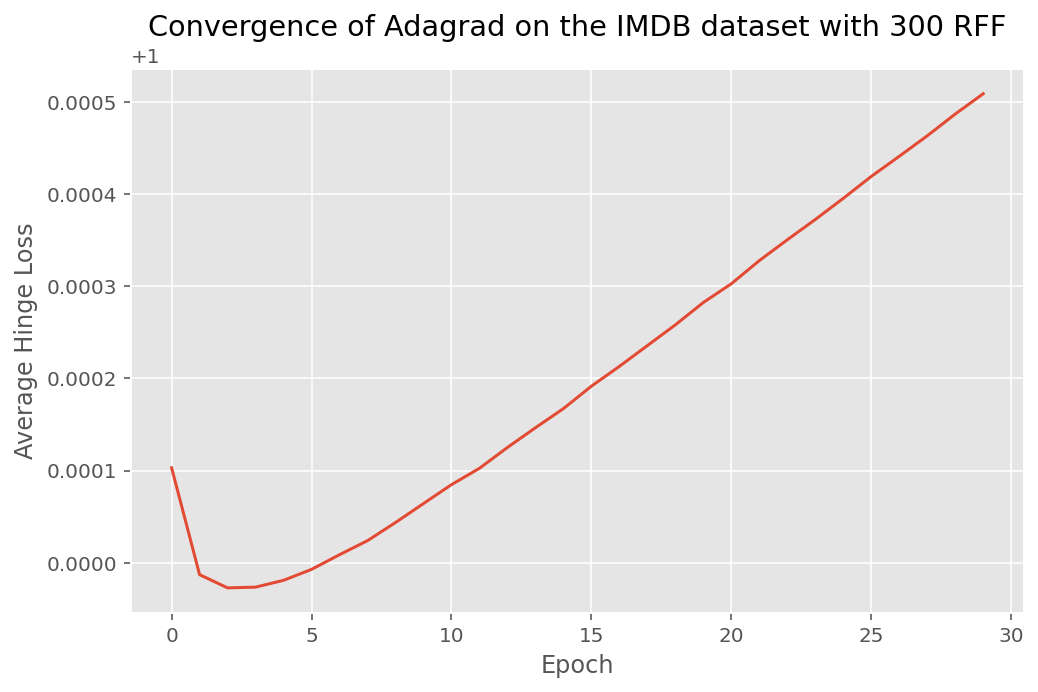

Accuracy on the IMDB dataset: 0.49
Runtime on the IMDB dataset: 23.41


In [52]:
n_components = [100, 200, 300]
np.random.seed(420)

for num in n_components:

    model = LinearSVM(lambda_=0.1)
    optimizer = Adagrad(learning_rate=0.001)
    
    rff = RandomFourierFeatures(n_components=num, gamma=0.1)
    X_train_val_imdb_rff = rff.fit_transform(X_train_val_imdb)
    X_test_imdb_scaled_rff = rff.transform(X_test_imdb_scaled)
    
    start_time = time.time()
    loss = model.fit(X_train_val_imdb_rff, y_train_val_imdb, optimizer, n_epochs=30, batch_size=10)
    runtime = time.time() - start_time

    test_pred = model.predict(X_test_imdb_scaled_rff)
    accuracy = accuracy_score(y_test_imdb, test_pred)

    # Plotting convergence
    print('')
    print(f"Number of RFF = {num}")

    plt.plot(loss)
    plt.title(f"Convergence of Adagrad on the IMDB dataset with {num} RFF")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

    print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
    print(f"Runtime on the IMDB dataset: {runtime:.2f}")

For IMDB, report the runtime and performance (in plots or a single plot) when training on 1000, 2000, and 3000 training samples, respectively. Report the same when using sklearn’s svm.SVC class.

Training Progress: 100%|██████████| 30/30 [00:00<00:00, 42.08it/s, loss=0.997]



Number of training samples = 1000


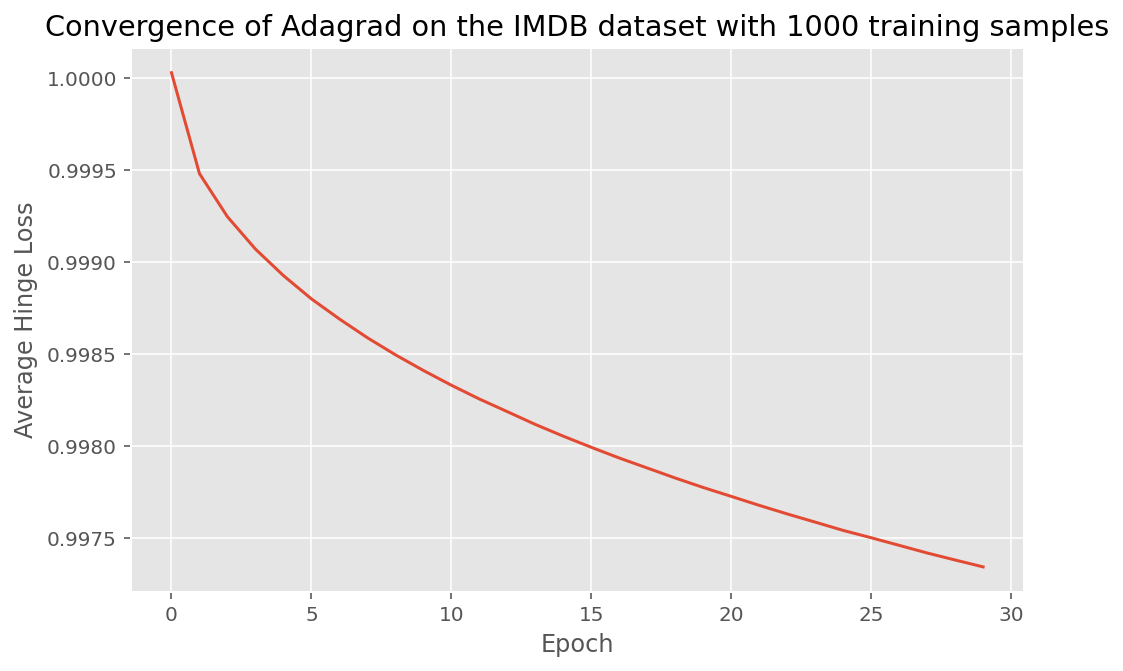

Accuracy on the IMDB dataset: 0.50
Runtime on the IMDB dataset: 0.82


Training Progress: 100%|██████████| 30/30 [00:00<00:00, 33.88it/s, loss=0.999]



Number of training samples = 2000


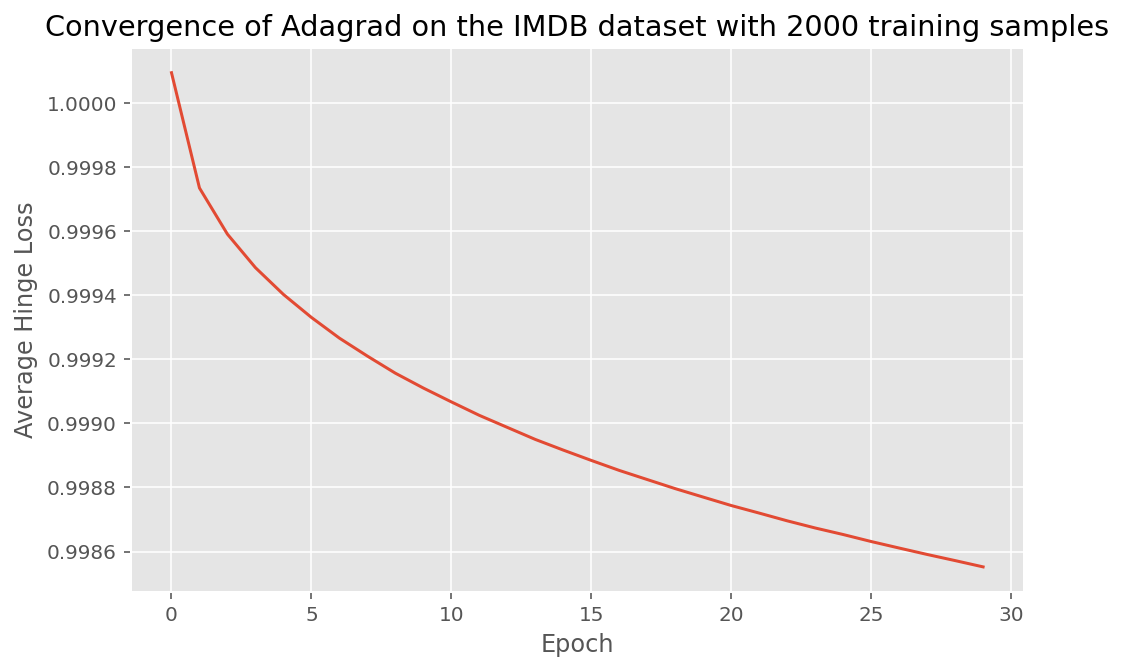

Accuracy on the IMDB dataset: 0.50
Runtime on the IMDB dataset: 1.04


Training Progress: 100%|██████████| 30/30 [00:01<00:00, 19.91it/s, loss=0.999]



Number of training samples = 3000


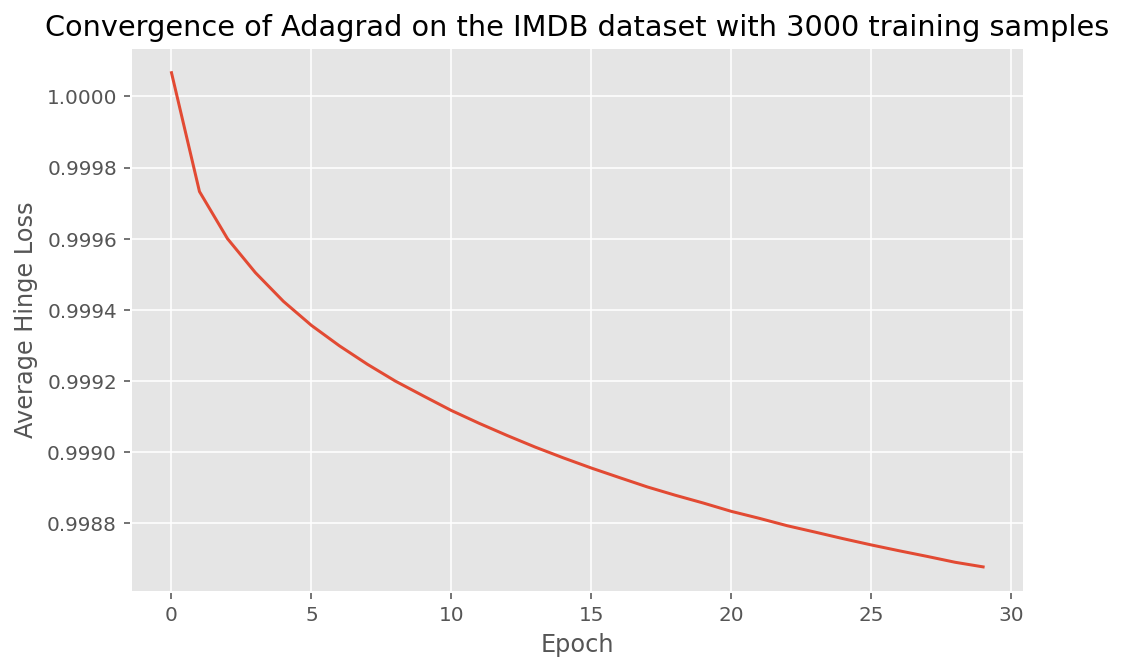

Accuracy on the IMDB dataset: 0.50
Runtime on the IMDB dataset: 1.76


In [55]:
train_samples = [1000, 2000, 3000]
np.random.seed(420)

for n_samples in train_samples:

    model = LinearSVM(lambda_=0.1)
    optimizer = Adagrad(learning_rate=0.001)
    
    rff = RandomFourierFeatures(n_components=100, gamma=0.1)
    X_train_val_imdb_rff = rff.fit_transform(X_train_val_imdb)
    indices = np.random.choice(X_train_val_imdb_rff.shape[0], n_samples, replace=False)
    X_train_val_imdb_rff_subset = X_train_val_imdb_rff[indices]
    y_train_val_imdb_subset = y_train_val_imdb[indices]

    X_test_imdb_scaled_rff = rff.transform(X_test_imdb_scaled)
    
    start_time = time.time()
    loss = model.fit(X_train_val_imdb_rff_subset, y_train_val_imdb_subset, optimizer, n_epochs=30, batch_size=10)
    runtime = time.time() - start_time

    test_pred = model.predict(X_test_imdb_scaled_rff)
    accuracy = accuracy_score(y_test_imdb, test_pred)

    # Plotting convergence
    print('')
    print(f"Number of training samples = {n_samples}")

    plt.plot(loss)
    plt.title(f"Convergence of Adagrad on the IMDB dataset with {n_samples} training samples")
    plt.xlabel('Epoch')
    plt.ylabel('Average Hinge Loss')
    plt.show()

    print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
    print(f"Runtime on the IMDB dataset: {runtime:.2f}")

Now let's do the same for sklearn's SVM:

In [59]:
train_samples = [1000, 2000, 3000]
np.random.seed(420)

for n_samples in train_samples:
    
    rff = RandomFourierFeatures(n_components=100, gamma=0.1)
    X_train_val_imdb_rff = rff.fit_transform(X_train_val_imdb)
    indices = np.random.choice(X_train_val_imdb_rff.shape[0], n_samples, replace=False)
    X_train_val_imdb_rff_subset = X_train_val_imdb_rff[indices]
    y_train_val_imdb_subset = y_train_val_imdb[indices]

    X_test_imdb_scaled_rff = rff.transform(X_test_imdb_scaled)
    
    start_time = time.time()
    accuracy = cross_val_sk(SVC(C=0.1, kernel='linear'), X_train_val_imdb_rff_subset, y_train_val_imdb_subset, cv=5)
    runtime = time.time() - start_time

    accuracy = np.mean(accuracy)

    # Plotting convergence
    print('')
    print(f"Number of training samples = {n_samples}")

    print(f"Accuracy on the IMDB dataset: {accuracy:.2f}")
    print(f"Runtime on the IMDB dataset: {runtime:.2f}")


Number of training samples = 1000
Accuracy on the IMDB dataset: 0.52
Runtime on the IMDB dataset: 0.25

Number of training samples = 2000
Accuracy on the IMDB dataset: 0.51
Runtime on the IMDB dataset: 1.21

Number of training samples = 3000
Accuracy on the IMDB dataset: 0.51
Runtime on the IMDB dataset: 2.67
